# Insert SOILGRIDS-derived soil class in SUMMA set up
Inserts mode soil class of each HRU into the attributes `.nc` file. The intersection code stores a histogram of soil classes in fields `USGS_{0,1,...,12}`.

In [2]:
# modules
import os
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime

#### Control file handling

In [3]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [4]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [5]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [6]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find shapefile location and name

In [7]:
# Path to and name of shapefile with intersection between catchment and soil classes
intersect_path = read_from_control(controlFolder/controlFile,'intersect_soil_path')
intersect_name = read_from_control(controlFolder/controlFile,'intersect_soil_name')

In [8]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_soilgrids') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [9]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### Find where the attributes file is

In [10]:
# Attribute path & name
attribute_path = read_from_control(controlFolder/controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFolder/controlFile,'settings_summa_attributes')

In [11]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA') # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the files and fill the placeholder values in the attributes file

In [12]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

In [23]:
# Open the netcdf file for reading+writing
with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
    
    # Loop over the HRUs in the attributes
    for idx in range(0,len(att['hruId'])):
        
        # Find the HRU ID (attributes file) at this index
        attribute_hru = att['hruId'][idx]
    
        # Find the row in the shapefile that contains info for this HRU
        shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
        
        # Extract the histogram values
        tmp_hist = []
        for j in range (0,13):
            if 'USGS_' + str(j) in shp.columns:
                tmp_hist.append(shp['USGS_' + str(j)][shp_mask].values[0])
            else:
                tmp_hist.append(0)
                
        # Set the '0' class to having -1 occurences -> that must make some other class the most occuring one. 
        # Using -1 also accounts for cases where SOILGRIDS has no sand/silt/clay data (oceans, glaciers, open water)
        # and returns soil class =0. In such cases we default to the soilclass with the second most occurences. If 
        # tied, we use the first in the list. We should never return soilclass = 0 in this way.
        tmp_hist[0] = -1
        
        # Find the index with the most occurences
        # Note: this assumes that we have USGS_0 to USGS_12 and thus that index == soilclass. 
        tmp_sc = np.argmax(np.asarray(tmp_hist))
        
        # Check the assumption that index == soilclass
        if shp['USGS_' + str(tmp_sc)][shp_mask].values != tmp_hist[tmp_sc]:
            print('Index and mode soil class do not match at hru_id ' + \
                  str(shp[intersect_hruId_var][shp_mask].values[0]))
            tmp_sc = -999
            
        # Replace the value
        print('Replacing soil class {} with {} at HRU {}'.format(att['soilTypeIndex'][idx],tmp_sc,attribute_hru))
        att['soilTypeIndex'][idx] = tmp_sc

Replacing soil class 3 with 3 at HRU 1
Replacing soil class 3 with 3 at HRU 2
Replacing soil class 3 with 3 at HRU 3
Replacing soil class 3 with 3 at HRU 4
Replacing soil class 3 with 3 at HRU 5
Replacing soil class 3 with 3 at HRU 6
Replacing soil class 3 with 3 at HRU 7
Replacing soil class 3 with 3 at HRU 8
Replacing soil class 3 with 3 at HRU 9
Replacing soil class 3 with 3 at HRU 10
Replacing soil class 3 with 3 at HRU 11
Replacing soil class 3 with 3 at HRU 12
Replacing soil class 3 with 3 at HRU 13
Replacing soil class 3 with 3 at HRU 14
Replacing soil class 3 with 3 at HRU 15
Replacing soil class 3 with 3 at HRU 16
Replacing soil class 3 with 3 at HRU 17
Replacing soil class 3 with 3 at HRU 18
Replacing soil class 3 with 3 at HRU 19
Replacing soil class 3 with 3 at HRU 20
Replacing soil class 3 with 3 at HRU 21
Replacing soil class 3 with 3 at HRU 22
Replacing soil class 3 with 3 at HRU 23
Replacing soil class 3 with 3 at HRU 24
Replacing soil class 3 with 3 at HRU 25
Replacing

## Check

In [12]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [14]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [15]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [16]:
# temporarily store the soiltype in the shape for plotting
shp['soilTypeIndex'] = att['soilTypeIndex'][:]

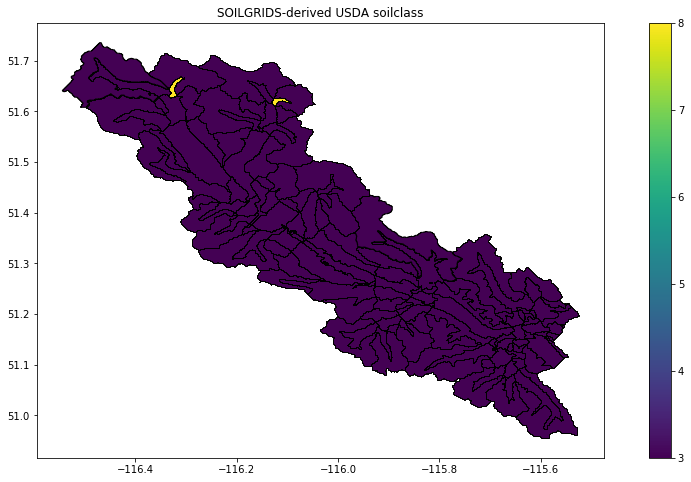

In [17]:
# Make a bplot to see what we did
shp.plot(column='soilTypeIndex',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('SOILGRIDS-derived USDA soilclass');

In [ ]:
# Close the netCDF file
att.close()

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [34]:
# Set the log path and file name
logPath = attribute_path
log_suffix = '_add_soil_to_attributes.txt'

In [35]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [74]:
# Copy this script
thisFile = '2a_insert_soilclass_from_hist_into_attributes.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [38]:
# Get current date and time
now = datetime.now()

In [39]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Added soil classes to attributes .nc file.']
    for txt in lines:
        file.write(txt) 